<h1><center>Northeastern University</center></h1>
<h1><center>EECE 7150 Autonomous Field Robotics</center></h1>
<h1><center>HW3 Submission</center></h1>
<h3><center>Yash Mewada</center></h3>
<h3><center>Date: 25th Sept, 2023</center></h3>

<h3>Part 1</h3>


Modify your registration module from the previous home works to allow you to robustly match features across two images. Please continue to work with Python Notebooks as much as possible.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from operator import sub
import gtsam
import gtsam.utils.plot as gtsam_plot
import os
import math


class hw3():
    def __init__(self,path_to_dataset):
        """
        Constructor for hw3 class
        Args:
            path_to_dataset (str): path to dataset
        """
        self.path_to_dataset = path_to_dataset
    
    def pixelCoorNormalise(self,coor,img)->tuple:
        """
        Normalise pixel coordinate to range [-1,1]
        Args:
            coor (tuple): (x,y) coordinate
            img (np.array): image

        Returns:
            tuple: (x,y) coordinate normalised
        """
        x,y = coor
        h,w = img.shape[:2]
        return (2*x/w - 1,2*y/h - 1)

    def pixelCoorDenormalise(self,coor,img)->tuple:
        """
        Denormalise pixel coordinate to range [0,255]
        Args:
            coor (tuple): (x,y) coordinate
            img (np.array): image

        Returns:
            tuple: (x,y) coordinate denormalised
        """
        x,y = coor
        h,w = img.shape[:2]
        return (float((x+1)*w/2),float((y+1)*h/2))
    
    def performCLAHE(self,img):
        """
        Perform CLAHE on image
        Args:
            img (np.array): image
        """
        assert img is not None, "file could not be read, check with os.path.exists()"
        # create a CLAHE object (Arguments are optional).
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(img)
        return cl1
        
        
    def siftDetctor(self,img1,img2):
        """
        sift feature detector

        Args:
            img1 (np.array): image 1 
            img2 (np.array): image 2

        Returns:
            img3 (np.array): image with matches
            kp1 (list): Normalised list of keypoints in image 1
            kp2 (list): Normalised list of keypoints in image 2
        """
        
        img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
        
        # img1 = self.performCLAHE(img1)
        # img2 = self.performCLAHE(img2)
        
        sift = cv2.SIFT_create()
        kp1,des1 = sift.detectAndCompute(img1,None)
        kp2,des2 = sift.detectAndCompute(img2,None)
    
        # Brute Force Matching
        matches = sorted(cv2.BFMatcher(cv2.NORM_L1,crossCheck=True).match(des1,des2),key=lambda x:x.distance)
        goodkp2 = [kp2[mat.trainIdx] for mat in matches]
        goodkp1 = [kp1[mat.queryIdx] for mat in matches]
        #print(goodkp1[0].pt)

        img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:50],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        return img3,goodkp1,goodkp2
    
    def PoissonImageBlending(self,source, destination):
        # create an all "White" mask: 255, if black mask is 0
        mask = 255 * np.ones(destination.shape, destination.dtype) 
        # navigate the source img location
        width, height, channels = source.shape
        center = (height//2, width//2)

        # using built-in funtion `cv2.seamlessClone` to acommpulish Poisson Image
        blended = cv2.seamlessClone(destination, source, mask, center, 3) # cv::MIXED_CLONE = 2
        output = blended
        return output
    
    def featherBlending(self,A,B):
        """
        Feather gradeint blending
        """
        assert A is not None, "file could not be read, check with os.path.exists()"
        assert B is not None, "file could not be read, check with os.path.exists()"
        # generate Gaussian pyramid for A
        G = A.copy()
        gpA = [G]
        for i in range(6):
            G = cv2.pyrDown(G)
            gpA.append(G)
        # generate Gaussian pyramid for B
        G = B.copy()
        gpB = [G]
        for i in range(6):
            G = cv2.pyrDown(G)
            gpB.append(G)
        # generate Laplacian Pyramid for A
        lpA = [gpA[5]]
        for i in range(5,0,-1):
            GE = cv2.pyrUp(gpA[i])
            L = cv2.subtract(gpA[i-1],GE)
            lpA.append(L)
        # generate Laplacian Pyramid for B
        lpB = [gpB[5]]
        for i in range(5,0,-1):
            GE = cv2.pyrUp(gpB[i])
            L = cv2.subtract(gpB[i-1],GE)
            lpB.append(L)
        # Now add left and right halves of images in each level
        LS = []
        for la,lb in zip(lpA,lpB):
            rows,cols,dpt = la.shape
            ls = np.hstack((la[:,0:cols//2], lb[:,cols//2:]))
            LS.append(ls)
        # now reconstruct
        ls_ = LS[0]
        for i in range(1,6):
            ls_ = cv2.pyrUp(ls_)
            ls_ = cv2.add(ls_, LS[i])
        # image with direct connecting each half
        real = np.hstack((A[:,:cols//2],B[:,cols//2:]))
        return ls_,real

    def computeHomography(self,kp1,kp2,img1,img2):
        """
        Compute homography matrix

        Args:
            kp1 (list): Normalised list of keypoints in image 1
            kp2 (list): Normalised list of keypoints in image 2

        Returns:
            H (np.array): Homography matrix
        """
        kp1 = np.array([kp.pt for kp in kp1])
        kp2 = np.array([kp.pt for kp in kp2])
        H,mask = cv2.findHomography(kp1,kp2,cv2.RANSAC)
        # H,mask  = cv2.estimateAffinePartial2D(kp1,kp2)
        # # H = H[:2,:]
        # homogenous = np.array([[0,0,1]])
        # H = np.concatenate((H,homogenous),axis=0)
        # mathchesMask = mask.ravel().tolist()
        return H

    def computeAffine(self,kp1,kp2):
        """
        Compute affine matrix
        Args:
            kp1 (_type_): _description_
            kp2 (_type_): _description_
            img1 (_type_): _description_
            img2 (_type_): _description_
        """
        kp1 = np.array([kp.pt for kp in kp1])
        kp2 = np.array([kp.pt for kp in kp2])
        H,_  = cv2.estimateAffinePartial2D(kp1,kp2)
        H = H[:2,:]
        homogenous = np.array([[0,0,1]])
        H = np.concatenate((H,homogenous),axis=0)
        
        scale = np.sqrt(H[0,0]**2 + H[1,0]**2)
        H[:2,:2] /= scale
        affine_mat = H
        return affine_mat
    
    def overlay_two_images(self,img1,img2,ignore_color = [0,0,0]):
        ignore_color = np.asarray(ignore_color)
        mask = (img2==ignore_color).all(-1,keepdims=True)
        out = np.where(mask,img1,(img1 * 0.5 + img2 * 0.5).astype(img1.dtype))
        return out
    
    def mean_blend(self,img1, img2):
        assert(img1.shape == img2.shape)
        locs1 = np.where(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY) != 0)
        blended1 = np.copy(img2)
        blended1[locs1[0], locs1[1]] = img1[locs1[0], locs1[1]]
        locs2 = np.where(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY) != 0)
        blended2 = np.copy(img1)
        blended2[locs2[0], locs2[1]] = img2[locs2[0], locs2[1]]
        blended = cv2.addWeighted(blended1, 0.8, blended2, 0.2, 0)
        # blended = self.PoissonImageBlending(blended1,blended2)
        return blended
    
    def warpImage(self,img1,img2,H,height,width,crop_black=True):
        """
        Warp image 1 to image 2
        """
        
        h,w = img1.shape[:2]
        pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
        dst = cv2.warpPerspective(img1,H,(width,height))
        #print(img2.shape)
        # blended = self.PoissonImageBlending(dst,img2)sss
        
        # blended = cv2.addWeighted(img2,0.5,dst,0.5,0)
        blended = self.mean_blend(img2,dst)
        final = np.zeros((img2.shape[0] + img2.shape[0],img2.shape[1] + img2.shape[1],3),np.uint8)
        # # find center of the final canvas
        
        if crop_black:
            final[0:img2.shape[0],0:img2.shape[1]] = blended
            x,y,w,h = cv2.boundingRect(cv2.findNonZero(cv2.cvtColor(final, cv2.COLOR_BGR2GRAY)))
            final = final[y:y+h,x:x+w]
        
        else:
            (cx,cy) = (final.shape[1]//2,final.shape[0]//2)
            # find center of the blended image
            (bx,by) = (blended.shape[1]//2,blended.shape[0]//2)
            # merge the blended image to the final canvas such that the center of the blended image is at the center of the final canvas
            final[cy-by:cy-by+blended.shape[0],cx-bx:cx-bx+blended.shape[1]] = blended
        # final = np.asarray(np.nonzero(final),dtype=np.uint8)
        # #print(h,w)

        return blended
    

        
        


In [23]:
class colors:
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    YELLOW = '\033[33m'
    RESET = '\033[0m'

In [24]:
def findHallimgs(hw3:hw3,dataset:str):
    
    image_lsit = []
    dataset = os.path.join(hw3.path_to_dataset,dataset)
    files = os.listdir(dataset)
    files.sort()
    
    # images_29 = []
    # files = []
    # for root, dirs, f in os.walk(dataset):
    #     for file in f:
    #         # Get the full path of the file
    #         file_path = os.path.join(root, file)
    #         files.append(file_path)
    #         # Process the file (e.g., read, copy, or analyze it)
    # files.sort()
    # print(files)
    for file,i in zip(files,range(len(files))):
        if i < 2:
            img = cv2.imread(os.path.join(dataset,file),cv2.IMREAD_GRAYSCALE)
            clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(5,5))
            cl1 = clahe.apply(img)
            cl1 = cv2.cvtColor(cl1,cv2.COLOR_GRAY2BGR)
            image_lsit.append(cl1)
        else:
            img = cv2.imread(os.path.join(dataset,file))
            image_lsit.append(img)
        
    H_d = {}
    n_features = {}
    aff1 = {}
    for i in range(len(image_lsit)-1):
        key = str(i)+str(i+1)
        # print(colors.BLUE+"Computing Homography for image pair: "+key+colors.RESET)
        _,kp1,kp2 = hw3.siftDetctor(image_lsit[i],image_lsit[i+1])
        n_features[i] = len(kp1)
        H = hw3.computeHomography(kp1,kp2,image_lsit[i],image_lsit[i+1])
        aff1[key] = hw3.computeAffine(kp1,kp2)
        H_d[key] = H
    print(n_features.keys())
    used_keys = []
    H_new = {}

                    
    aff = {}
    H_init = H_d['01']
    # H = [H_d['01']]
    for key1 in H_d:
        for key2 in H_d:
            new_key = key1[0] + key2[1]  # Generate the new key
            swapped_key = key2[0] + key1[1]  # Generate the swapped key
            # Check conditions to ensure that swapped keys and duplicates are avoided
            if (key1 != key2) and (new_key not in used_keys) and (swapped_key not in used_keys):
                # print("Non consecutive frames")
                cumulative_H = H_init
                current_key = key1
                while current_key[1] != key2[1]:
                    next_key = f"{current_key[1]}{str(int(current_key[1]) + 1)}"
                    cumulative_H = np.dot(cumulative_H,H_d[next_key])  # Adjust this based on your key format
                    cumulative_H[2,2] = 1
                    current_key = next_key
                _,kp1,kp2 = hw3.siftDetctor(image_lsit[int(key1[0])],image_lsit[int(key2[1])])
                aff[new_key] = hw3.computeAffine(kp1,kp2)
                print(f"{colors.YELLOW}Affine matrix for image pair: {key1[0]}"  "{key2[1]} computed{colors.RESET}")
                H_new[new_key] = cumulative_H
                
                used_keys.append(new_key)
                
    aff.update(aff1)
    H_d.update(H_new)
    
    # print(f"{colors.GREEN}Homography matrix for all image pairs computed{colors.RESET}",H.keys())
    print(f"{colors.GREEN}Homography matrix for all image pairs computed{colors.RESET}",H_d.keys())
    print(f"{colors.GREEN}Affine matrix for all image pairs computed{colors.RESET}",aff.keys())
    
    _,kp1,kp2 = hw3.siftDetctor(image_lsit[0],image_lsit[1])
    n12 = len(kp1)
    H12 = hw3.computeHomography(kp1,kp2,image_lsit[0],image_lsit[1])
    
    
    _,kp3,kp4 = hw3.siftDetctor(image_lsit[1],image_lsit[2])
    n23 = len(kp3)
    H23 = hw3.computeHomography(kp3,kp4,image_lsit[1],image_lsit[2])
    
    H13 = np.dot(H23,H12)
    H13[2,2] = 1
    
    _,kp5,kp6 = hw3.siftDetctor(image_lsit[2],image_lsit[3])
    n34 = len(kp5)
    H34 = hw3.computeHomography(kp5,kp6,image_lsit[2],image_lsit[3])
    
    H14 = np.dot(H34,H13)
    H14[2,2] = 1
    
    _,kp7,kp8 = hw3.siftDetctor(image_lsit[3],image_lsit[4])
    n45 = len(kp7)
    H45 = hw3.computeHomography(kp7,kp8,image_lsit[3],image_lsit[4])
    
    H15 = np.dot(H45,H14)
    H15[2,2] = 1
    
    _,kp9,kp10 = hw3.siftDetctor(image_lsit[4],image_lsit[5])
    n56 = len(kp9)
    H56 = hw3.computeHomography(kp9,kp10,image_lsit[4],image_lsit[5])
    

    H16 = np.dot(H56,H15)
    H16[2,2] = 1
    
    n = [n12,n23,n34,n45,n56]
    H = [H12,H13,H14,H15,H16]
    # keys = ['01', '12', '02', '23', '03', '34', '04', '45', '05']
    
    # H_dict = dict(zip(keys,H))
    return H_d,image_lsit,H,n_features,aff
    

In [25]:
def addBorder(img, rect):
    top, bottom, left, right = int(0), int(0), int(0), int(0)
    x, y, w, h = rect
    tl = (x, y)    
    br = (x + w, y + h)
    if tl[1] < 0:
        top = -tl[1]
    if br[1] > img.shape[0]:
        bottom = br[1] - img.shape[0]
    if tl[0] < 0:
        left = -tl[0]
    if br[0] > img.shape[1]:
        right = br[0] - img.shape[1]
    img = cv2.copyMakeBorder(img, top, bottom, left, right,
                            cv2.BORDER_CONSTANT, value=[0, 0, 0])
    orig = (left, top)
    return img, orig

def patchPano(hw3:hw3,img1, img2, orig1=(0,0), orig2=(0,0)):
    # bottom right points
    br1 = (img1.shape[1] - 1, img1.shape[0] - 1)
    br2 = (img2.shape[1] - 1, img2.shape[0] - 1)
    # distance from orig to br
    diag2 = tuple(map(sub, br2, orig2))
    # possible pano corner coordinates based on img1
    extremum = np.array([(0, 0), br1,
                tuple(map(sum, zip(orig1, diag2))),
                tuple(map(sub, orig1, orig2))])
    bb = cv2.boundingRect(extremum)
    # patch img1 to img2
    pano, shift = addBorder(img1, bb)
    orig = tuple(map(sum, zip(orig1, shift)))
    idx = np.s_[orig[1] : orig[1] + img2.shape[0] - orig2[1],
                orig[0] : orig[0] + img2.shape[1] - orig2[0]]
    subImg = img2[orig2[1] : img2.shape[0], orig2[0] : img2.shape[1]]
    pano[idx] = hw3.mean_blend(pano[idx], subImg)
    # pano[idx] = hw3.featherBlending(pano[idx], subImg)
    return np.array(pano), orig

In [26]:
def getShift(image,H):
    corners = np.float32([[0,0],[0,image.shape[0]-1],[image.shape[1]-1,image.shape[0]-1],[image.shape[1]-1,0]])
    H_corners = []
    # transform these point to the respective homography
    for p in corners:
        # #print(p)
        p = np.array([p[0],p[1],1])
        p = np.dot(np.linalg.inv(H),p)
        p = p/p[2]
        H_corners.append(p)
    
    shift = (float("inf"),float("inf"))
    for p in H_corners:
        # get the least negative x and y
        if p[0] < shift[0]:
            shift_x = int(p[0]) + 60
        if p[1] < shift[1]:
            shift_y = int(p[1])
        shift = (abs(shift_x),shift_y)

    return shift

def stichfromH(hw3:hw3,H,image_list):
    
    h,w = image_list[0].shape[0]*2 ,image_list[0].shape[1]*2
    stitch12 = cv2.warpPerspective(image_list[1],np.linalg.inv(H[0]),(w,h))
    pano12,_ = patchPano(hw3,image_list[0], stitch12)
    
    # Stitch images 1,2 and 3
    h,w = image_list[0].shape[0]*3 ,image_list[0].shape[1]*3
    stitch13 = cv2.warpPerspective(image_list[2],np.linalg.inv(H[1]),(w,h))
    pano13,_ = patchPano(hw3,pano12, stitch13)
    
    # add padding eqauls to the shift amount in x
    shift = getShift(image_list[3],H[2]) # transform these point to the respective homography
    h,w = image_list[0].shape[0] + shift[1],image_list[0].shape[1] + shift[0]
    img4 = np.zeros((image_list[3].shape[0],image_list[3].shape[1] + shift[0],3),np.uint8)

    img4[:,shift[0]:image_list[3].shape[1] + shift[0]] = image_list[3]
    stitch14 = cv2.warpPerspective(img4,np.linalg.inv(H[2]),(w,h))
    pano13 = np.roll(pano13,shift[0],axis=1)
    pano14,_ = patchPano(hw3,pano13, stitch14)
    
    # stitch images 1,2,3,4 and 5
    shift = getShift(image_list[4],H[3])
    h,w = image_list[0].shape[0] + shift[1],image_list[0].shape[1] + shift[0]
    img5 = np.zeros((image_list[4].shape[0],image_list[4].shape[1] + shift[0],3),np.uint8)
    img5[:,shift[0]:image_list[4].shape[1] + shift[0]] = image_list[4]
    stitch15 = cv2.warpPerspective(img5,np.linalg.inv(H[3]),(w,h))
    # stitch15 = np.roll(stitch15,shift[0]-50,axis=1)
    pano15,_ = patchPano(hw3,pano14, stitch15)
    
    # stitch images 1,2,3,4,5 and 6
    shift = getShift(image_list[5],H[4])
    h,w = image_list[0].shape[0] + shift[1],image_list[0].shape[1] + shift[0]
    img6 = np.zeros((image_list[5].shape[0],image_list[5].shape[1] + shift[0],3),np.uint8)
    img6[:,shift[0]:image_list[5].shape[1] + shift[0]] = image_list[5]
    stitch16 = cv2.warpPerspective(img6,np.linalg.inv(H[4]),(w,h))
    # stitch16 = np.roll(stitch16,shift[0]-50,axis=1)
    pano16,_ = patchPano(hw3,pano15, stitch16)
    
    x,y,w,h = cv2.boundingRect(cv2.findNonZero(cv2.cvtColor(pano16, cv2.COLOR_BGR2GRAY)))
    pano16 = pano16[y:y+h,x:x+w]
    return pano16
    
    
def stitchformHdynamic(hw3:hw3,H,image_list):
    pano_images = []

    pano_image = image_list[0]
    
    for key,values in H.items():
        # if key.startswith('0'):
        H = values
        shift = getShift(image_list[int(key[1])],H)
        # print(f"shift: {shift}")
        h,w = image_list[0].shape[0] + shift[1],image_list[0].shape[1] + shift[0]
        
        new_image = np.zeros((image_list[int(key[1])].shape[0],image_list[int(key[1])].shape[1] + shift[0],3),np.uint8)
        new_image[:,shift[0]:image_list[int(key[1])].shape[1] + shift[0]] = image_list[int(key[1])]
        stitched_image = cv2.warpPerspective(new_image,np.linalg.inv(H),(w,h))
        # if key == '04':
        pano_image = np.roll(pano_image,shift[0],axis=1)
        pano_image = np.roll(pano_image,shift[1],axis=0)
        pano_image,_ = patchPano(hw3,pano_image,stitched_image)
        pano_images.append(pano_image)
    return pano_image
    
    # for i in range(len(H)):
    #      # Calculate the shift and dimensions
    #     shift = getShift(image_list[i], H[i])
    #     h, w = image_list[0].shape[0] + shift[1], image_list[0].shape[1] + shift[0]

    #     # Create a new image with padding
    #     new_image = np.zeros((image_list[i].shape[0], image_list[i].shape[1] + shift[0], 3), np.uint8)
    #     new_image[:, shift[0]:image_list[i].shape[1] + shift[0]] = image_list[i]

    #     # Warp the new image using the inverse of the homography matrix
    #     stitched_image = cv2.warpPerspective(new_image, np.linalg.inv(H[i]), (w, h))

    #     # Roll the previous stitched image
    #     pano_image = np.roll(pano_image, shift[0], axis=1)

    #     # Patch the images
    #     pano_image, _ = patchPano(hw3, pano_image, stitched_image)

    #     # Append the stitched image to the list
    #     pano_images.append(pano_image)
    
    

**Feature Detector** - In part 1, I found that Clahe only worked for me for inital 2/3 images, hence I only applied CLAHE to those images.This code uses Brute Force Matcher (BF Matcher) to find the matches and get the good matches out of those. I am using SIFT detector here. I also tested it with ORB, but the output by ORB gets worse after 4 images, (which should not be the case as in certain papers they claim that ORB outperforms SIFT because of its bitwise descriptor).

**RANSAC** - The Homography matrix estimation is done by RANSAC. I also tried estimating the affine transformation matrix,but the results were a bit off.

**Image Stitching and Panorama generation** - For panorama generation and estimating the location of image before sticching, I take four corners of the image and then multiply it with its respective H matrix. Then in those four warped points if any of the *x,y* is out of canvas i.e negative, I shit the previous panorama/image by the absolute value of that shift i.e (np.roll), hence giving me shift in X and Y axes. After the shifts are available I warp and stitch the images.

**Mean/Alpha Bleding** - I found while naively applying alpha blending is it also blends the black pixels of the warped image hence making the blended image darker and darker as the number of images increases, hence I applied what I call a "*Mean Blending*", here I copy the non zeros pixels of both the images and then perform Alpha blending hence, only the non zero pixels gets blended.

**Note** - The implementation of all above methods is in *main* function below.

<h3>Part 2</h3>
Go around the entire loop of 6 images and set up the problem by outputting vertices and edges in terms of a factor graph

**Pose 2 genetation** - We all know that the H matrix is a combination of camera intrinsics, Rotation and Translation matrix as.
$\mathbf{H} = \mathbf{K} \cdot \mathbf{R} \cdot \mathbf{T}$, Where:
\begin{align*}
    \mathbf{K} & : \text{Intrinsic camera matrix} \\
    \mathbf{R} & : \text{Extrinsic rotation matrix} \\
    \mathbf{T} & : \text{Extrinsic translation vector} \\
\end{align*}
Hence we can obtain the tranlation from the right top most element of the H matrix as:
$\mathbf{H} =
\begin{bmatrix}
    h_{11} & h_{12} & x \\
    h_{21} & h_{22} & y \\
    h_{31} & h_{32} & 1 \\
\end{bmatrix}$
Then I did SVD of the top left matrix of this H matrix to obtaint the Rotation matrix and then $\tan^{-1}$ will give me the pose of the image.

This pose is then further given to the factor graph to generate the graph and then eventually optimise it using *Levenberg-Marquardt* algorithm.
**Note** - Plot graph function is taken from ZZ's code.



In [27]:
def create_pose2(hw3:hw3,dataset):
    H_dict,image_list,_,n,_ = findHallimgs(hw3,dataset)
    MAX_MATCHES = max(n.values())
    # #print("H",H)
    w,h = image_list[0].shape[1],image_list[0].shape[0]
        
    #prior mean and noise model and taking center of the image as the prior pose
    priorMean = gtsam.Pose2(w/2,h/2,0)
    PRIOR_NOISE_MODEL = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
    ODOM_NOISE_MODEL = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))
    
    graph = gtsam.NonlinearFactorGraph()
    graph.add(gtsam.PriorFactorPose2(0, priorMean, PRIOR_NOISE_MODEL))
    
    def extractHomographyPose(h):
        affineEst = h
        affineEst[2][0] = 0
        affineEst[2][1] = 0
        #print(affineEst)
        scale = np.sqrt(affineEst[0,0]**2+affineEst[1,0]**2) # adapted from ZZ
        affineEst[:2, :2] /= scale
        rot = affineEst[:2, :2]
        total_affine_matrix = np.eye(3)

        affineEst_inv = np.linalg.inv(affineEst)
        affineEst = affineEst_inv.dot(total_affine_matrix)
        return gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                    np.arctan2(affineEst[1, 0], affineEst[0, 0]))
    # add odometry factors
    initial = gtsam.Values()
    initial.insert(0, gtsam.Pose2())
    i = 1
    for key, value in H_dict.items():
        if key.startswith('0'):
            H = value
            print(H)
            # scale = np.sqrt(H[0,0]**2 + H[1,0]**2)
            # H[:2,:2] /= scale
            # print(H)
            x,y = H[0,-1],H[1,-1]
            U, _, Vt = np.linalg.svd(H[:2, :2])
            R = np.dot(U, Vt)
            theta = np.arctan2(R[1,0],R[0,0])
            pose = gtsam.Pose2(x,y,theta)
            # pose = extractHomographyPose(value)
            initial.insert(i, pose)
            i += 1
    
    def getNoise(x,y,th,n):
        # A part of this function is implemented form Curtis's Code
        covar_multiplier = math.exp(n - MAX_MATCHES) # Normalize by the maximum expected number of matches
        exx = abs(x / 2) * covar_multiplier
        eyy = abs(y / 2) * covar_multiplier
        ett = abs(th / (2 * 10.0)) * covar_multiplier
        diag_noise = np.array([exx, eyy, ett])
        return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(diag_noise))
    
    i = 0
    for key,value in H_dict.items():
        H = value
        x,y = H[0,-1],H[1,-1]
        U, _, Vt = np.linalg.svd(H[:2, :2])
        R = np.dot(U, Vt)
        theta = np.arctan2(R[1,0],R[0,0])
        src = int(key[0])
        dst = int(key[1])
        if i < 5:
            ODOM_NOISE_MODEL = getNoise(x,y,theta,n[i])
        graph.add(gtsam.BetweenFactorPose2(src,dst,gtsam.Pose2(x,y,theta),ODOM_NOISE_MODEL))
        i += 1

    #print("\nFactor Graph:\n{}".format(graph))
    return graph,initial

def plot_graph(values,graph,marginals):
    #print("Values:\n{}".format(values))
    #print("Marginals:\n{}".format(marginals))
    for vertex_index in range(values.size()):
        gtsam_plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

def reconstructH(result,imwidth,imheight):
    poses = gtsam.utilities.allPose2s(result)
    H_dict = []
    # print(poses.size())
    for i in range(poses.size()):
        pose = poses.atPose2(i)
        affine_H = pose.matrix()
        translation_matrix = np.eye(3)
        translation_matrix[:2,2] -= np.array([imwidth/2,imheight/2]).T
        affine_H = np.dot(affine_H,translation_matrix)
        affine_H = np.linalg.inv(affine_H)
        H_dict.append(affine_H)
    # print(len(H_dict))
    return H_dict
        

The way I have calculated the covariance is based on the number of matches between the images, the more the matches the less the covariance. I have used the following formula to calculate the covariance:
\begin{align*}
    \text{covar\_multiplier} = \exp(n - \text{MAX\_MATCHES})\\
    exx = \left| \frac{x}{30} \right| \cdot \text{covar\_multiplier}\\
    eyy = \left| \frac{y}{30} \right| \cdot \text{covar\_multiplier}\\
    ett = \left| \frac{\theta}{30 \cdot 10.0} \right| \cdot \text{covar\_multiplier}\\
    \text{diag\_noise} = [ \text{exx}, \text{eyy}, \text{ett} ]
\end{align*}
The above expression is called exponential scaling of covariance based on the number of matches. Exponential scaling, which can provide more drastic adjustments based on the number of matches.


LIN_DIV is a constant or parameter that is used to divide the displacement values dx, dy, and dth in order to normalize them before applying the scaling factor covar_multiplier. It's essentially a divisor used to adjust the sensitivity of the covariance scaling based on the size of the displacement.

The choice of LIN_DIV should be based on the scale and units of your motion or displacement measurements. It can be used to control how much the covariance scales with respect to the magnitude of motion. A smaller LIN_DIV will result in larger covariances for the same magnitude of motion, while a larger LIN_DIV will result in smaller covariances.


OUTPUT for 6 images


dict_keys([0, 1, 2, 3, 4])
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 3{key2[1]} computed{colors.RESET}
Homography matrix for all image pairs computed dict_keys(['01', '12', '23', '34', '45', '02', '03', '04', '05', '13', '14', '15', '24', '25', '35'])
Affine matrix for all image pairs computed dict_keys(['02', '03', '04', '05', '13', '14', '15', '24', '25', '35', '01', '12', '23', '34', '45'])


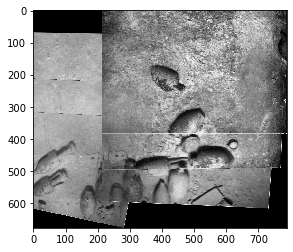

Before Optimisation
dict_keys([0, 1, 2, 3, 4])
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 3{key2[1]} computed{colors.RESET}
Homography matrix for all image pairs computed dict_keys(['01', '12', '23', '34', '45', '02', '03', '04', '05', '13', '14', '15', '24', '25', '35'])
Affine matrix for all image pairs computed dict_keys(['02', '03', '04', '05', '13', '14', '15', '24', '25', '35', '01', '12', '23', '34', '45'])
[[ 9.65741736e-01 -

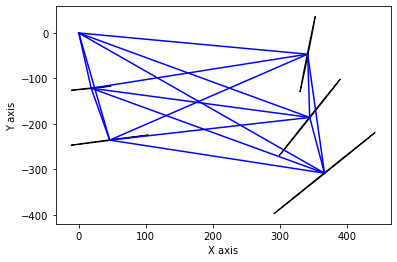

After Optimisation
Result Values with 6 values:
Value 0: (gtsam::Pose2)
(287.998, 191.999, -0.0449536)

Value 1: (gtsam::Pose2)
(309.431, 75.6778, -0.0720126)

Value 2: (gtsam::Pose2)
(323.43, -45.8514, -0.0609422)

Value 3: (gtsam::Pose2)
(636.153, -132.728, 0.0464344)

Value 4: (gtsam::Pose2)
(618.189, -8.56477, -0.160011)

Value 5: (gtsam::Pose2)
(628.729, 139.188, -0.245365)




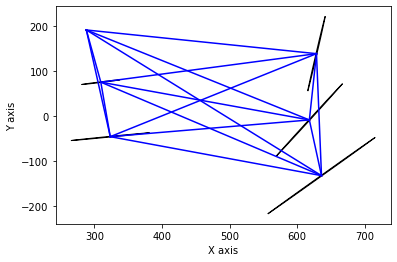

OUTPUT for 29 images 3rd column
dict_keys([0, 1, 2, 3, 4, 5])
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 3{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 3{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 4{key2[1]} c

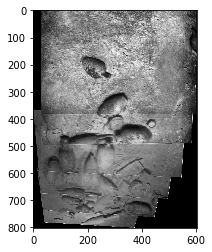

Before Optimisation
dict_keys([0, 1, 2, 3, 4, 5])
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 0{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 1{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 2{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 3{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 3{key2[1]} computed{colors.RESET}
Affine matrix for image pair: 4{key2[1]} computed{colo

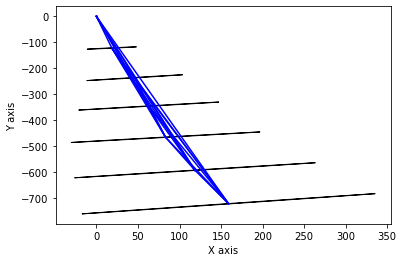

After Optimisation
Result Values with 7 values:
Value 0: (gtsam::Pose2)
(288, 192, -8.43271e-09)

Value 1: (gtsam::Pose2)
(307.677, 74.7905, 0.0357988)

Value 2: (gtsam::Pose2)
(334.031, -43.7806, 0.0541491)

Value 3: (gtsam::Pose2)
(348.932, -158.559, 0.0746179)

Value 4: (gtsam::Pose2)
(363.678, -287.002, 0.173086)

Value 5: (gtsam::Pose2)
(401.266, -405.293, 0.236953)

Value 6: (gtsam::Pose2)
(447.021, -529.239, 0.0971293)




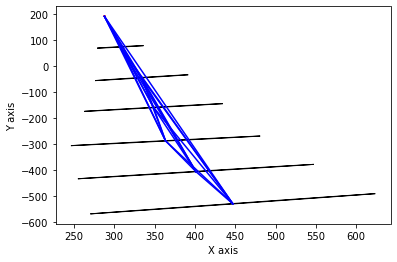

In [28]:
    
if __name__ == "__main__":
    
    print(f"{colors.BLUE}OUTPUT for 6 images{colors.RESET}")
    dataset = "/home/mewada/Documents/AFR/eece7150/HW3/Dataset/6Images/"
    hw31 = hw3(dataset)
    H_d,image_list,H,_,_ = findHallimgs(hw31,dataset)
    imwidth,imheight = image_list[0].shape[1],image_list[0].shape[0]
    pano16 = stichfromH(hw31,H,image_list)
    # cv2.imshow("pano16",pano16)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(pano16)
    plt.show()
    
    print(f"{colors.BLUE}Before Optimisation{colors.RESET}")
    graph,initial = create_pose2(hw31,dataset)
    print(f"{colors.BLUE}Initials{colors.RESET}",initial)
    marginals = gtsam.Marginals(graph,initial)
    plot_graph(initial,graph,marginals)
    initial_h = reconstructH(initial,imwidth,imheight)
    # print(len(initial_h))
    pano_before_opt = stichfromH(hw31,initial_h,image_list)
    cv2.imshow("pano_before_opt",pano_before_opt)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    print(f"{colors.GREEN}After Optimisation{colors.RESET}")
    params = gtsam.LevenbergMarquardtParams()
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
    result = optimizer.optimize()
    print(f"{colors.BLUE}Result{colors.RESET}",result)
    marginals = gtsam.Marginals(graph, result)
    plot_graph(result, graph, marginals)
    
    result_h = reconstructH(result,imwidth,imheight)
    
        
    pano_after_opt = stichfromH(hw31,result_h,image_list)
    cv2.imshow("pano_after_opt",pano_after_opt)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    
    print(f"{colors.BLUE}OUTPUT for 29 images 3rd column{colors.RESET}")
    dataset = "/home/mewada/Documents/AFR/eece7150/HW3/Dataset/29images/29images/third column/"
    hw3 = hw3(dataset)
    H_d,image_list,H,_,_ = findHallimgs(hw3,dataset)
    pano16 = stichfromH(hw3,H,image_list)
    plt.imshow(pano16)
    plt.show()
    
    print(f"{colors.BLUE}Before Optimisation{colors.RESET}")
    graph,initial = create_pose2(hw3,dataset)
    print(f"{colors.BLUE}Initials{colors.RESET}",initial)
    marginals = gtsam.Marginals(graph,initial)
    plot_graph(initial,graph,marginals)
    
    
    
    print(f"{colors.GREEN}After Optimisation{colors.RESET}")
    params = gtsam.LevenbergMarquardtParams()
    optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
    result = optimizer.optimize()
    print(f"{colors.BLUE}Result{colors.RESET}",result)
    marginals = gtsam.Marginals(graph, result)
    plot_graph(result, graph, marginals)
    
    H_dict = reconstructH(result,imwidth,imheight)
    H1 = np.identity(3)
    img1 = cv2.warpPerspective(image_list[0],H1,(image_list[0].shape[1]*2,image_list[0].shape[0]*2))
    img2 = cv2.warpPerspective(image_list[1],H_dict[1],(image_list[1].shape[1]*2,image_list[1].shape[0]*2))
    pano12,_ = patchPano(hw3,img1, img2)
    cv2.imshow("pano12",pano12)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


    
        

It is seen from the above output that the factor graph optimization worked but not significantly in 6 images case as the initial estimates were good but there is a slight decrease in errors as the graph optimises.
I tried it with 29 images, but the kernel was crashing as I was trying to process all the images at once. If time persists I will try and upload the output of all 29 images, but for now I tried just the third column of the 29 images.